In [1]:
# Initialization

!pip install -Uqq fastai
!pip install duckduckgo_search
!pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 22.1.0
    Uninstalling aiofiles-22.1.0:
      Successfully uninstalled aiofiles-22.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.0 MB/s eta 0:00:00


In [2]:
# uses nbdev, uncomment if required
# doc(verify_images)

In [3]:
# Define funtion to search for images from DuckDuckGo to be used for training and testing classifier

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=10):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'rose photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


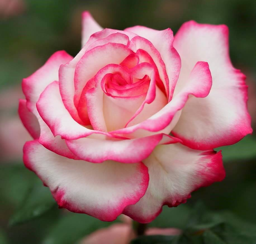

In [4]:
# Search for rose
urls = search_images('rose photos', max_images=1)
urls[0]

from fastdownload import download_url
# Download rose
dest = 'rose.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
# Display rose
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'carnation photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


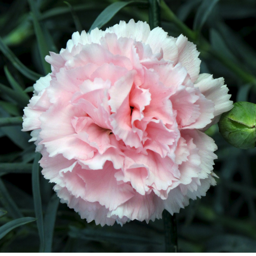

In [5]:
# Download and display carnation
download_url(search_images('carnation photos', max_images=1)[0], 'carnation.jpg', show_progress=False)
Image.open('carnation.jpg').to_thumb(256,256)

In [6]:
# Downaload data images for carnation and rose
searches = 'carnation','rose'
path = Path('carnation_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'carnation photo'
Searching for 'carnation sun photo'
Searching for 'carnation shade photo'
Searching for 'rose photo'
Searching for 'rose sun photo'
Searching for 'rose shade photo'


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

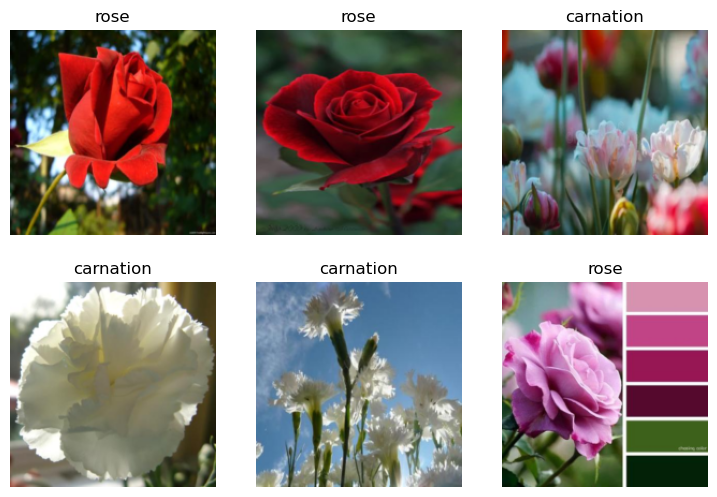

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

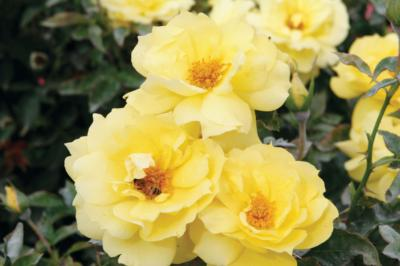

In [9]:
img, label = dls.loaders[0].dataset[0]
img

In [10]:
label

TensorCategory(1)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.8MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.969062,5.332990,0.545455,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.812801,4.007761,0.545455,00:01
1,0.896971,2.408100,0.545455,00:00
2,0.682500,1.369793,0.545455,00:00
3,0.522523,0.623970,0.363636,00:00
4,0.421698,0.304033,0.090909,00:00
5,0.354471,0.226126,0.090909,00:00


In [12]:
is_carnation,_,probs = learn.predict(PILImage.create('carnation.jpg'))
print(f"This is a: {is_carnation}.")
print(f"Probability it's a carnation: {probs[0]:.4f}")
print(f"Probability it's a rose: {probs[1]:.4f}")

This is a: carnation.
Probability it's a carnation: 0.9978
Probability it's a rose: 0.0022
